In [1]:
import scipy.stats
import scipy.optimize
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

n_i = np.full(4, 50)
x_i = np.array([0.0542217351633235, -0.7058565689642957, 0.5411263138456900, 1.1393884075711429])
p_i = np.array([0.5135521136895386, 0.3305150325484877, 0.6320743881220601, 0.7575673322021476])
y_i = np.array([28, 14, 33, 36])
rinla_cis = np.array([
    [-0.2914459, 0.7714731],
    [-1.399438, -0.1621846],
    [0.05145177, 1.165792],
    [0.2554444, 1.437953]
])

In [2]:
def calc_precision_matrixQ(Qv):
    return np.diag(np.full(x_i.shape[0], Qv))

def calc_log_prior(a, Qv):
    return scipy.stats.norm.logpdf(a, 0, 1) + scipy.stats.lognorm.logpdf(Qv, 10.0)

def calc_log_joint(x, y, n, a, Qv):
    Q = calc_precision_matrixQ(Qv)
    term1 = -(x-a).T.dot(Q).dot(x-a) / 2
    term2 = np.sum(x*y -n * np.log(np.exp(x) + 1))
    term3 = np.log(np.linalg.det(Q)) / 2
    term4 = calc_log_prior(a, Qv)
    return term1 + term2 + term3 + term4

In [3]:
def proposal(x, sigma=0.25):
    rv = scipy.stats.norm.rvs(x, sigma, size=6)
    ratio = 1
    return rv, ratio

def joint(xstar):
    a = xstar[-2]
    Qv = xstar[-1]
    return np.exp(calc_log_joint(xstar[:4], y_i, n_i, a, Qv))

x0 = np.zeros(6)
x0[-1] = 1
x0

array([0., 0., 0., 0., 0., 1.])

In [23]:
x = x0
Jx = joint(x)
x_chain = [x]
J_chain = [Jx]
accept = [True]
iterations = 50000

for i in range(iterations):
    xstar, ratio = proposal(x)
    if xstar[-1] < 0.0:
        continue

    Jxstar = joint(xstar)
    hastings_ratio = (Jxstar * ratio) / Jx
    if hastings_ratio > 1 or np.random.uniform(0, 1) < hastings_ratio:
        # accept
        x = xstar
        Jx = Jxstar
        accept.append(True)
    else:
        accept.append(False)
    
    x_chain.append(x) 
    J_chain.append(Jx)

In [24]:
x_chain = np.array(x_chain)
J_chain = np.array(J_chain)
accept = np.array(accept)

In [25]:
burn_in_n = 500
x_chain_burnin = x_chain[burn_in_n:]

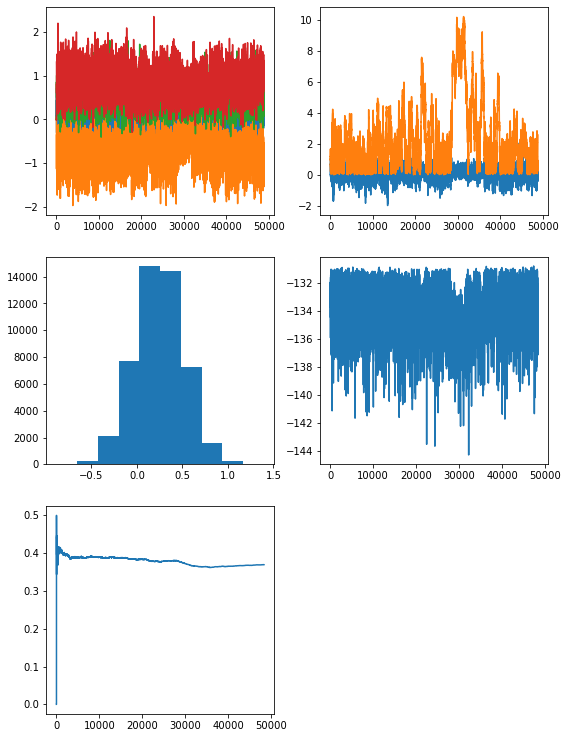

In [26]:
plt.figure(figsize=(9,13))
plt.subplot(3,2,1)
plt.plot(x_chain[:, :4])
plt.subplot(3,2,2)
plt.plot(x_chain[:, 4:])
plt.subplot(3,2,3)
plt.hist(x_chain_burnin[:, 0])
plt.subplot(3,2,4)
plt.plot(np.log(J_chain[burn_in_n:]))
plt.subplot(3,2,5)
plt.plot(np.cumsum(accept[burn_in_n:]) / (np.arange(x_chain_burnin.shape[0]) + 1))
plt.show()

In [29]:
ci025n = int(x_chain_burnin.shape[0] * 0.025)
ci975n = int(x_chain_burnin.shape[0] * 0.975)
for j in range(6):
    x_sorted = x_chain_burnin[:,j].copy()
    x_sorted.sort()
    x_mean = x_sorted.mean()
    print(j, x_sorted[ci025n], x_i[j] if j < 4 else 0, x_mean, x_sorted[ci975n])

0 -0.2795259089704156 0.0542217351633235 0.24505711627906257 0.7638946538502919
1 -1.4353436942216264 -0.7058565689642957 -0.7800134947492301 -0.18652910763945532
2 0.06951230996193192 0.54112631384569 0.6050459419438017 1.1705026241219563
3 0.2560703804283968 1.139388407571143 0.8377583241253685 1.4626408906232085
4 -0.7490716840783477 0 0.17878069951774755 1.0744456941612366
5 0.1957026120873499 0 2.2686185123336338 8.198888988715526
